Referência: <br>
    https://naysan.ca/2020/05/09/pandas-to-postgresql-using-psycopg2-bulk-insert-performance-benchmark/<br>
    https://github.com/NaysanSaran/pandas2postgresql

In [1]:
import pandas as pd 
import numpy as np
import os
import sys

from datetime import date, datetime
import time
from timeit import default_timer as timer

!pip install psycopg2
import psycopg2
import psycopg2.extras as extras

import os
from io import StringIO

!pip install wget
import wget

from zipfile import ZipFile

from bs4 import BeautifulSoup as bs
import requests
import re

Configurando banco de dados

In [2]:
# Here you want to change your database, username & password according to your own values
param_dic = {
    "host"      : "dataiesb.iesbtech.com.br",
    "database"  : "IESB_Empresas",
    "user"      : "1922120026_TCC_Thiago",
    "password"  : "1922120026_TCC_Thiago"
}

In [19]:
def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        #print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    #print("Connection successful")
    return conn

conn = connect(param_dic)

In [4]:
# Função para criar tabela no banco
def criar_db(sql):
    con = connect(param_dic)
    cur = con.cursor()
    cur.execute(sql)
    con.commit()
    con.close()

In [ ]:
# Criando a tabela para os dados de município
sql = '''CREATE TABLE IF NOT EXISTS 
tb_aux_municipio (
cd_municipio varchar(255), 
municipio varchar(255));'''

criar_db(sql)

Baixando arquivo

In [5]:
url = "http://200.152.38.155/CNPJ/"
res = requests.get(url)

try:
    res.status_code=200
    print("URL acessível")
except:
    print("URL não acessível. Page Status = "+res.status_code)

URL acessível


In [9]:
# Extraindo conteúdo do site 
html_page = pd.read_html(url)
# Convertando o conteúdo obtido em um dataframe pandas
table_files = html_page[0]
# Excluindo colunas indesejáveis
table_files.drop(["Unnamed: 0", "Description"], axis=1, inplace=True)
# Excluindo linhas vazias (NaN)
table_files=table_files = table_files.dropna().reset_index(drop=True)
# Excluindo outras linhas com conteúdo indesejável
table_files=table_files.drop([21,38]).reset_index(drop=True)
table_files.sort_values(by='Name')

table_files_series = pd.Series(list(table_files["Name"]))

links=[]

for n in range(0,len(table_files_series)):
    url_completa = url+table_files_series.loc[n]
    links.append(url_completa)

link_municipio = links[22:23]
link_municipio

['http://200.152.38.155/CNPJ/Municipios.zip']

In [6]:
path_drive = 'C:/Users/thiago.silva/TCC/RFB_CNPJ'

subdir_path = path_drive + '/temp'
os.makedirs(subdir_path, exist_ok=True)

os.chdir(path_drive+'/temp')

path_drive_tmp = 'C:/Users/thiago.silva/TCC/RFB_CNPJ/temp'

In [11]:
# Criando uma barra de progresso para ser chamado no wget
def bar_progress(current, total, width=80):
    progress_message = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
    sys.stdout.write("\r" + progress_message)
    sys.stdout.flush()

def etl_cnpj_rfb(links):
      for i in range(0, len(links)):
        filename = wget.download(links[i],path_drive_tmp,bar=bar_progress)

        with ZipFile(filename, 'r') as zipObj:
            print('\nExtraindo arquivo zip...')
            zipObj.extractall(path=path_drive_tmp)

        time.sleep(20)

        try:
            os.remove(filename)
        except OSError as e:
            print(e)
        else:
            pass

        tmp_file = os.listdir(path_drive_tmp)[0]
        filename_to_csv = 'Municipios.csv'

        os.rename(tmp_file, path_drive+'/'+filename_to_csv)

In [14]:
etl_cnpj_rfb(link_municipio)

Downloading: 100% [43436 / 43436] bytes
Extraindo arquivo zip...


Carregando arquivo baixado em dataframe

In [7]:
csv_file = path_drive+"/Municipios.csv"

names = ['cd_municipio',
         'municipio']

df = pd.read_csv(csv_file,  delimiter=';', header=None, names=names)
df.head()

,cd_municipio,municipio
0,1,GUAJARA-MIRIM
1,2,ALTO ALEGRE DOS PARECIS
2,3,PORTO VELHO
3,4,BURITIS
4,5,JI-PARANA


In [17]:
csv_file = path_drive+"/Simples.csv"

names = ['cnpj_base',
          'opcao_simples',
          'dt_opcao_simples',
          'dt_exclusao_simples',
          'opcao_mei',
          'dt_opcao_mei',
          'dt_exclusao_mei']

df = pd.read_csv(csv_file,  delimiter=';', header=None, names=names)
df.head()

,cnpj_base,opcao_simples,dt_opcao_simples,dt_exclusao_simples,opcao_mei,dt_opcao_mei,dt_exclusao_mei
0,0,N,20070701,20070701,N,20090701,20090701
1,6,N,20180101,20191231,N,0,0
2,8,N,20140101,20211231,N,0,0
3,11,S,20070701,0,N,0,0
4,13,S,20090101,0,N,0,0


In [18]:
def execute_query(conn, query):
    """ Execute a single query """
    
    ret = 0 # Return value
    cursor = conn.cursor()
    try:
        cursor.execute(query)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1

    # If this was a select query, return the result
    if 'select' in query.lower():
        ret = cursor.fetchall()
    cursor.close()
    return ret

Comparing the Bulk Insert Strategies

A - ExecuteMany

In [21]:
def execute_many(conn, df, table):
    """
    Using cursor.executemany() to insert the dataframe
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES(%%s,%%s)" % (table, cols)
    cursor = conn.cursor()
    try:
        cursor.executemany(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_many() done")
    cursor.close()

# Run the execute_many strategy
execute_many(conn, df, 'tb_aux_municipio')

execute_many() done


In [22]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from tb_aux_municipio;")

[(5571,)]

In [14]:
# Clear the table
execute_query(conn, "delete from tb_aux_municipio where true;")

0

B - ExecuteBatch

In [24]:
def execute_batch(conn, df, table, page_size=100):
    """
    Using psycopg2.extras.execute_batch() to insert the dataframe
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES(%%s,%%s)" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_batch(cursor, query, tuples, page_size)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_batch() done")
    cursor.close()


# Run the execute_many strategy
execute_batch(conn, df, 'tb_aux_municipio')

execute_batch() done


In [25]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from tb_aux_municipio;")

[(5571,)]

In [26]:
# Clear the table
execute_query(conn, "delete from tb_aux_municipio where true;")

0

C - ExecuteValues

In [27]:
def execute_values(conn, df, table):
    """
    Using psycopg2.extras.execute_values() to insert the dataframe
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_values() done")
    cursor.close()


# Run the execute_many strategy
execute_values(conn, df, 'tb_aux_municipio')

execute_values() done


In [28]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from tb_aux_municipio;")

[(5571,)]

In [29]:
# Clear the table
execute_query(conn, "delete from tb_aux_municipio where true;")

0

D - Mogrify() then execute()

In [30]:
def execute_mogrify(conn, df, table):
    """
    Using cursor.mogrify() to build the bulk insert query
    then cursor.execute() to execute the query
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    cursor = conn.cursor()
    values = [cursor.mogrify("(%s,%s)", tup).decode('utf8') for tup in tuples]
    query  = "INSERT INTO %s(%s) VALUES " % (table, cols) + ",".join(values)
    
    try:
        cursor.execute(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_mogrify() done")
    cursor.close()


# Run the execute_many strategy
execute_mogrify(conn, df, 'tb_aux_municipio')

execute_mogrify() done


In [31]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from tb_aux_municipio;")

[(5571,)]

In [32]:
# Clear the table
execute_query(conn, "delete from tb_aux_municipio where true;")

0

E - CopyFrom() - Save to disk first

In [93]:
def copy_from_file(conn, df, table):
    """
    Here we are going save the dataframe on disk as 
    a csv file, load the csv file  
    and use copy_from() to copy it to the table
    """
    # Save the dataframe to disk
    tmp_df = path_drive+"/tmp_dataframe.csv"
    df.to_csv(tmp_df, index=False, header=False)
    f = open(tmp_df, 'r')
    cursor = conn.cursor()
    try:
        cursor.copy_from(f, table, sep=",")
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        f.close()
        os.remove(tmp_df)
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("copy_from_file() done")
    cursor.close()
    f.close()
    os.remove(tmp_df)
    
# Run the execute_many strategy
copy_from_file(conn, df, 'tb_aux_municipio')

copy_from_file() done


In [94]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from tb_aux_municipio;")

[(5571,)]

In [95]:
# Clear the table
execute_query(conn, "delete from tb_aux_municipio where true;")

0

F - CopyFrom() - In memory using StringIO

In [15]:
def copy_from_stringio(conn, df, table):
    """
    Here we are going save the dataframe in memory 
    and use copy_from() to copy it to the table
    """
    # save dataframe to an in memory buffer
    buffer = StringIO()
    df.to_csv(buffer, index=False, header=False)
    buffer.seek(0)
    
    cursor = conn.cursor()
    try:
        cursor.copy_from(buffer, table, sep=",")
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("copy_from_stringio() done")
    cursor.close()


# Run the copy_from_stringio strategy
copy_from_stringio(conn, df, 'tb_aux_municipio')

copy_from_stringio() done


In [20]:
# Run the copy_from_stringio strategy
copy_from_stringio(conn, df, 'tb_simples')

copy_from_stringio() done


In [16]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from tb_aux_municipio;")

[(5571,)]

In [98]:
# Clear the table
execute_query(conn, "delete from tb_aux_municipio where true;")

0

G - to_sql() - From sqlalchemy

In [155]:
from sqlalchemy import create_engine

create_connect = "postgresql+psycopg2://%s:%s@%s:5432/%s" % (
    param_dic['user'],
    param_dic['password'],
    param_dic['host'],
    param_dic['database']
)

def to_alchemy(df):
    """
    Using a dummy table to test this call library
    """
    engine = create_engine(create_connect)
    df.to_sql(
        'tb_aux_municipio', 
        con=engine, 
        index=False, 
        if_exists='replace'
    )
    print("to_sql() done (sqlalchemy)")
    
    
to_alchemy(df)

to_sql() done (sqlalchemy)


In [156]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from tb_aux_municipio;")

[(5571,)]

In [157]:
# Clear the table
execute_query(conn, "delete from tb_aux_municipio where true;")

0

Benchmarking the performance of each strategy

In [161]:
def single_inserts(conn, df, table):
    """
    For benchmarking purposes, let's also implement a strategy in 
    which the inserts calls are done separately. Here we are 
    creating and closing a new cursor at each time, so this is probably 
    one of the slowest ways to achieve what we want.
    """
    cursor = conn.cursor()
    for i in df.index:
        cols = ','.join(list(df.columns))
        vals = tuple(df.loc[i, col].item() if isinstance(df.loc[i, col], np.int64) else df.loc[i, col] for col in list(df.columns))
        placeholders = ','.join(['%s'] * len(vals))
        query = "INSERT INTO %s (%s) VALUES (%s)" % (table, cols, placeholders)
        cursor.execute(query, vals)
    conn.commit()
    print("single_inserts() done")
    cursor.close()
        
#-----------------------------------------
# COMPARE THE SPEED OF EACH STRATRGY
#-----------------------------------------
def benchmark_bulk_inserts(df):
    execute_query(conn, "delete from tb_aux_municipio where true;")
    functions = [
        single_inserts, 
        execute_many, 
        execute_batch,
        execute_values, 
        execute_mogrify, 
        copy_from_file,
        copy_from_stringio
    ]
    exec_times = pd.DataFrame(index=range(len(functions)), columns=['nrows','strategy','time'])

    # Psycop2's functions
    i = 0
    for strategy in functions:
        print(str(strategy))
        start = timer()
        strategy(conn, df, 'tb_aux_municipio')
        end = timer()
        
        exec_times.at[i,'nrows'] = len(df.index)
        exec_times.at[i,'strategy'] = strategy.__name__
        exec_times.at[i,'time'] = end-start
        
        # Prepare for the next test
        execute_query(conn, "delete from tb_aux_municipio where true;")
        i = i + 1

    # Adding an extra test case for sqlalchemy's to_sql
    start = timer()
    to_alchemy(df)
    end = timer()
    exec_times.at[i,'nrows'] = len(df.index)
    exec_times.at[i,'strategy'] = "to_sql() | sqlalchemy"
    exec_times.at[i,'time'] = end-start
    
    return exec_times

benchmark_bulk_inserts(df)

<function single_inserts at 0x0000018EDD2E3880>
single_inserts() done
<function execute_many at 0x0000018EDC0D8430>
execute_many() done
<function execute_batch at 0x0000018EDA4804C0>
execute_batch() done
<function execute_values at 0x0000018EDBF092D0>
execute_values() done
<function execute_mogrify at 0x0000018ED9FE4CA0>
execute_mogrify() done
<function copy_from_file at 0x0000018EDCB0CA60>
copy_from_file() done
<function copy_from_stringio at 0x0000018EDCB0CEE0>
copy_from_stringio() done
to_sql() done (sqlalchemy)


,nrows,strategy,time
0,5571,single_inserts,946.601729
1,5571,execute_many,951.547883
2,5571,execute_batch,10.237214
3,5571,execute_values,11.053011
4,5571,execute_mogrify,0.599311
5,5571,copy_from_file,0.717249
6,5571,copy_from_stringio,0.720353
7,5571,to_sql() | sqlalchemy,8.234136


In [162]:
# Repeating our dataframe 30 times to get a large test dataframe
big_df = pd.concat([df]*31, ignore_index=True)
print(len(big_df.index))

172701


In [165]:
df_lst = []

conn = connect(param_dic)
cursor = conn.cursor()

for nrows in [1000,10000,50000,100000]:
    print("Nrows = %s" % nrows)
    test_df = big_df[0:nrows]
    perf_df = benchmark_bulk_inserts(test_df)
    df_lst.append(perf_df)
    

performances = pd.concat(df_lst, axis=0).reset_index()
performances.head(3)

Nrows = 1000
<function single_inserts at 0x0000018EDD2E3880>
single_inserts() done
<function execute_many at 0x0000018EDC0D8430>
execute_many() done
<function execute_batch at 0x0000018EDA4804C0>
execute_batch() done
<function execute_values at 0x0000018EDBF092D0>
execute_values() done
<function execute_mogrify at 0x0000018ED9FE4CA0>
execute_mogrify() done
<function copy_from_file at 0x0000018EDCB0CA60>
copy_from_file() done
<function copy_from_stringio at 0x0000018EDCB0CEE0>
copy_from_stringio() done
to_sql() done (sqlalchemy)
Nrows = 10000
<function single_inserts at 0x0000018EDD2E3880>
single_inserts() done
<function execute_many at 0x0000018EDC0D8430>
execute_many() done
<function execute_batch at 0x0000018EDA4804C0>
execute_batch() done
<function execute_values at 0x0000018EDBF092D0>
execute_values() done
<function execute_mogrify at 0x0000018ED9FE4CA0>
execute_mogrify() done
<function copy_from_file at 0x0000018EDCB0CA60>
copy_from_file() done
<function copy_from_stringio at 0x00

,index,nrows,strategy,time
0,0,1000,single_inserts,173.490333
1,1,1000,execute_many,172.132154
2,2,1000,execute_batch,2.149945


In [175]:
performances.head(50)

,index,nrows,strategy,time
0,0,1000,single_inserts,173.490333
1,1,1000,execute_many,172.132154
2,2,1000,execute_batch,2.149945
3,3,1000,execute_values,2.095316
4,4,1000,execute_mogrify,0.537664
5,5,1000,copy_from_file,0.710314
6,6,1000,copy_from_stringio,0.713797
7,7,1000,to_sql() | sqlalchemy,7.445474
8,0,10000,single_inserts,1737.432608
9,1,10000,execute_many,1742.944501


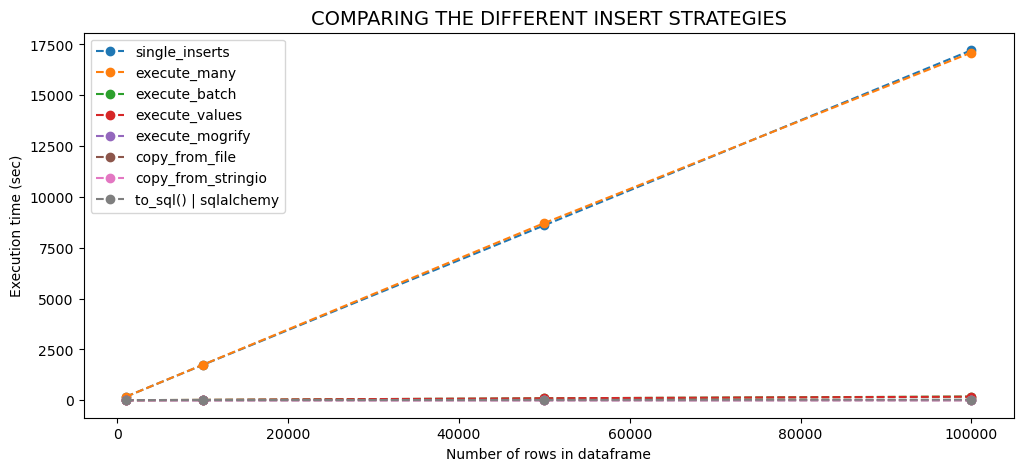

In [166]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,5))
for strategy in performances['strategy'].unique():
    subset = performances[performances['strategy'] == strategy]
    ax.plot(subset['nrows'], subset['time'], 'o--', label=strategy)

plt.xlabel('Number of rows in dataframe')
plt.ylabel('Execution time (sec)')
plt.title("COMPARING THE DIFFERENT INSERT STRATEGIES", fontsize=14)
plt.legend()
plt.savefig("./all_insert_strategies.png", dpi=400)
plt.show()

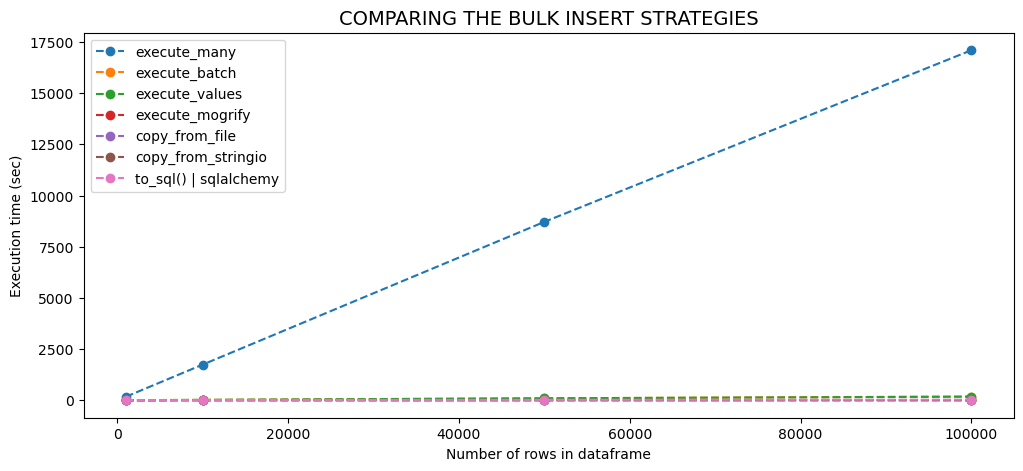

In [167]:
fig, ax = plt.subplots(figsize=(12,5))
for strategy in performances['strategy'].unique():
    if strategy != 'single_inserts':
        subset = performances[performances['strategy'] == strategy]
        ax.plot(subset['nrows'], subset['time'], 'o--', label=strategy)

plt.xlabel('Number of rows in dataframe')
plt.ylabel('Execution time (sec)')
plt.title("COMPARING THE BULK INSERT STRATEGIES", fontsize=14)
plt.legend()
plt.savefig("./benchmark.png", dpi=400)
plt.show()'

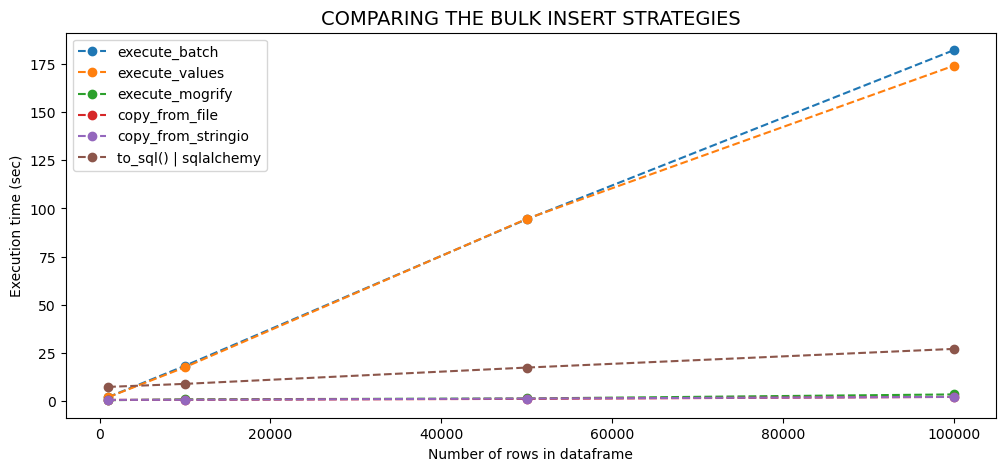

In [168]:
fig, ax = plt.subplots(figsize=(12,5))
for strategy in performances['strategy'].unique():
    if strategy != 'single_inserts' and strategy != 'execute_many':
        subset = performances[performances['strategy'] == strategy]
        ax.plot(subset['nrows'], subset['time'], 'o--', label=strategy)

plt.xlabel('Number of rows in dataframe')
plt.ylabel('Execution time (sec)')
plt.title("COMPARING THE BULK INSERT STRATEGIES", fontsize=14)
plt.legend()
plt.savefig("./benchmark.png", dpi=400)
plt.show()

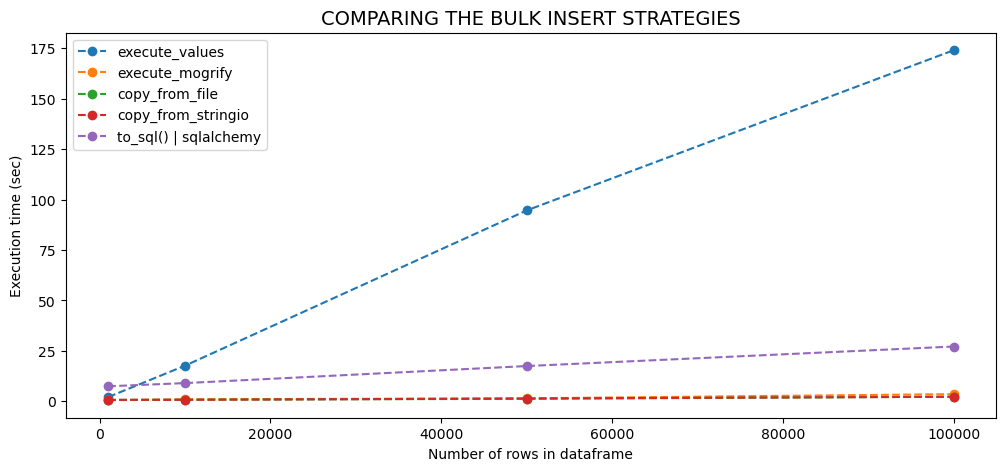

In [173]:
fig, ax = plt.subplots(figsize=(12,5))
for strategy in performances['strategy'].unique():
    if strategy != 'single_inserts' and strategy != 'execute_many' and strategy != 'execute_batch':
        subset = performances[performances['strategy'] == strategy]
        ax.plot(subset['nrows'], subset['time'], 'o--', label=strategy)

plt.xlabel('Number of rows in dataframe')
plt.ylabel('Execution time (sec)')
plt.title("COMPARING THE BULK INSERT STRATEGIES", fontsize=14)
plt.legend()
plt.savefig("./benchmark.png", dpi=400)
plt.show()

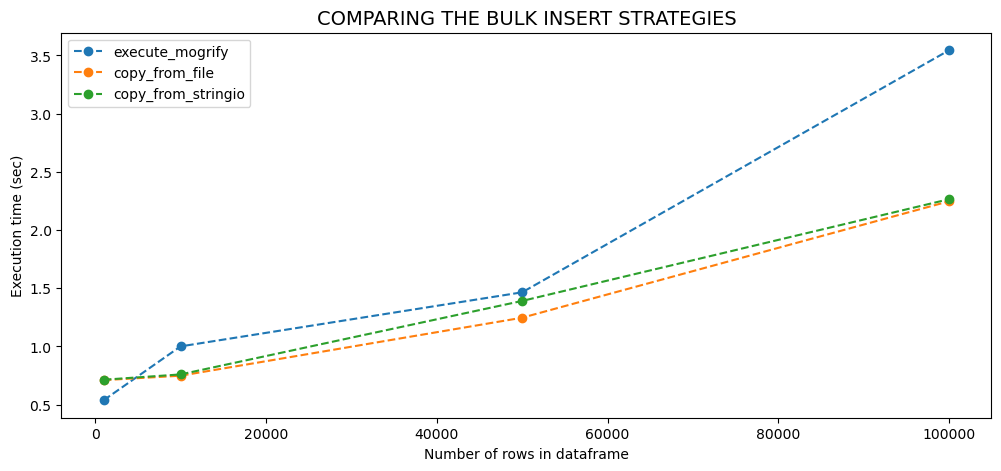

In [172]:
fig, ax = plt.subplots(figsize=(12,5))
for strategy in performances['strategy'].unique():
    if strategy != 'single_inserts' \
    and strategy != 'execute_many' \
    and strategy != 'execute_batch' \
    and strategy != 'execute_values' \
    and strategy != 'to_sql() | sqlalchemy':
        subset = performances[performances['strategy'] == strategy]
        ax.plot(subset['nrows'], subset['time'], 'o--', label=strategy)

plt.xlabel('Number of rows in dataframe')
plt.ylabel('Execution time (sec)')
plt.title("COMPARING THE BULK INSERT STRATEGIES", fontsize=14)
plt.legend()
plt.savefig("./benchmark.png", dpi=400)
plt.show()